# Contexto

El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.
- **date**: fecha y hora.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

# Librerías

In [3]:
# Importamos librerías a utilizar
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from haversine import haversine
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

import holidays
from haversine import haversine
from pandas import DataFrame

# Carga del dataset



In [4]:
# Carga de datos del dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)


# Análisis exploratorio de datos

## Análisis descriptivo

In [5]:
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
# Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

-Variables numéricas: fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, droptoff_latitude, passenger_count.

-Variables categóricas: key, date, pickup_datetime, passenger_count.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [8]:
# Valores nulos
df.isna().sum()

,0
key,0
date,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


## Análisis de datos atípicos

Para comenzar, quitamos los renglones en donde los valores de la columna objetivo sea nula o menor a 0

In [9]:
df = df[df["fare_amount"].notna()]
df = df[df["fare_amount"].astype(float) > 0]

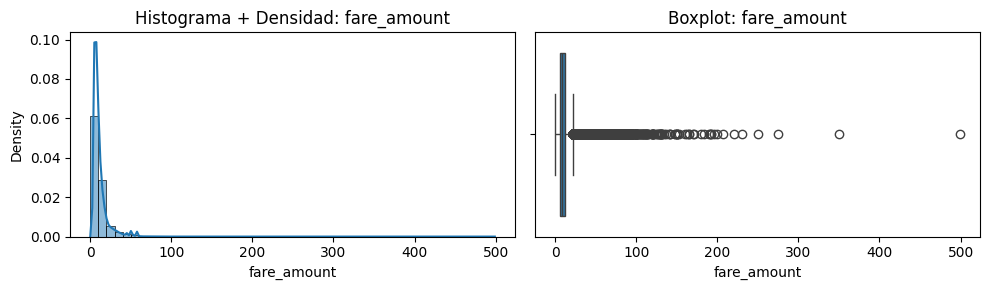

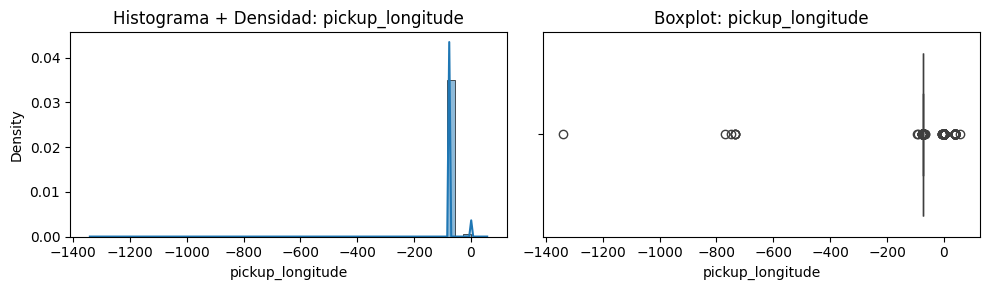

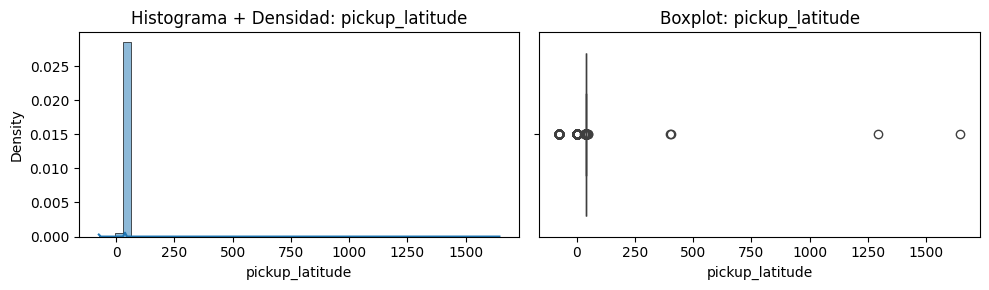

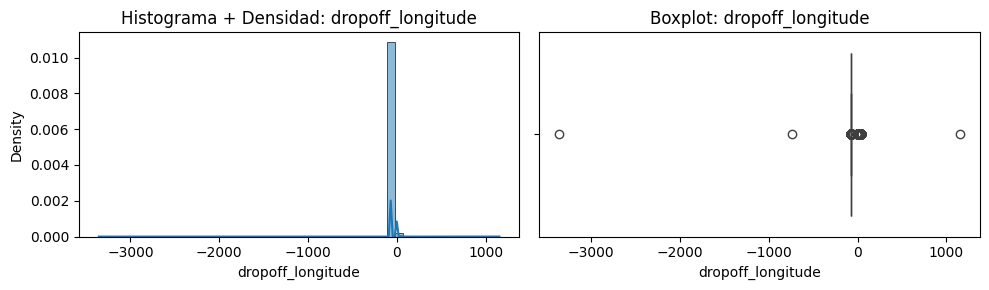

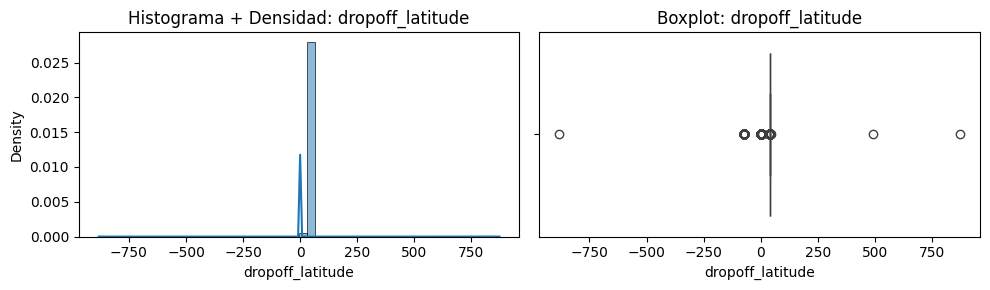

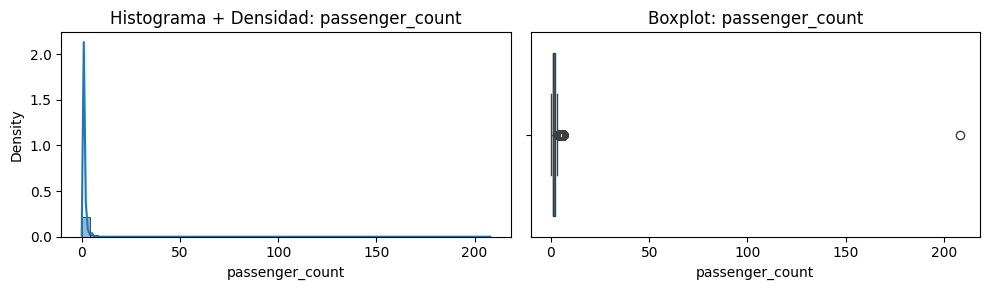

In [10]:
# Histogramas + densidad y boxplots
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('key')

def densityHistBoxPlot(df: DataFrame, cols: list):
    for c in cols:
        plt.figure(figsize=(10,3))

        # Histograma + densidad
        plt.subplot(1,2,1)
        sns.histplot(df[c].dropna(), bins=50, kde=True, stat="density")
        plt.title(f"Histograma + Densidad: {c}")

        # Boxplot
        plt.subplot(1,2,2)
        sns.boxplot(x=df[c].dropna())
        plt.title(f"Boxplot: {c}")

        plt.tight_layout()
        plt.show()

densityHistBoxPlot(df, num_cols)

En las gráficas podemos encontrar que hay valores atípicos sin sentido, como un Uber con más de 200 pasajeros o latitudes y longitudes que exceden los límites

## Codificación de variables categóricas

Divimos los casos de la cuenta de pasajeros según lo considerábamos un delivery, un servicio normal o uno premium, utilizando variables dummies para la misma

In [11]:
# Cantidad de pasajeros/as
df.loc[(df['passenger_count'] < 0), 'passenger_count'] = 0
df.loc[(df['passenger_count'] > 6), 'passenger_count'] = 6

# Crear categorías para cantidad de pasajeros
def categorize_passengers(count):
    if count == 0:
        return 'delivery'
    elif 1 <= count <= 4:
        return 'normal'
    elif 5 <= count <= 6:
        return 'xl'

df['passenger_category'] = df['passenger_count'].apply(categorize_passengers)

# Crear dummies para las categorías
passenger_dummies = pd.get_dummies(df['passenger_category'], prefix='passenger', dtype=int, drop_first=True)
df = pd.concat([df, passenger_dummies], axis=1)

# Dropear columnas que no serán utilizadas
df.drop(columns=['passenger_category','passenger_count'], inplace=True)

Se transforma la columna de fechas en componentes útiles (hora, día, semana, mes), generando variables binarias para franjas horarias y estaciones. Además, se codifican días de semana y semanas en el año con funciones seno/coseno y se marca fines de semana/feriados. Finalmente, se eliminan columnas intermedias innecesarias.

In [12]:
# Separar datetime en date y time
df["dateTime"] = pd.to_datetime(df["pickup_datetime"]) # sin errors, ya que checkeamos que no hay valores nulos
df["dateTime"] = df["dateTime"].dt.tz_convert("America/New_York") # Esto cubre el horario de verano

df["time"] = df["dateTime"].dt.hour
df["date"] = df["dateTime"].dt.date

# 1 a 7 ==> madrugada ==> V = 1  ==> CODIFICACIÓN BINARIA ==> 0 | 0
# 7 a 11 ==> mañana ==> V = 2 ==> CODIFICACIÓN BINARIA ==> 0 | 1
# 11 a 19 ==> tarde ==> V = 3 ==> CODIFICACIÓN BINARIA ==> 1 | 1
# 19 a 1 ==> noche ==> V = 4 ==> CODIFICACIÓN BINARIA ==> 1 | 0

df["bin_time_1"] = 0
df["bin_time_2"] = 0

df.loc[(df["time"] >= 7) & (df["time"] < 11), ["bin_time_1", "bin_time_2"]] = [0, 1]
df.loc[(df["time"] >= 11) & (df["time"] < 19), ["bin_time_1", "bin_time_2"]] = [1, 1]
df.loc[(df["time"] >= 19) | (df["time"] < 1), ["bin_time_1", "bin_time_2"]] = [1, 0]

# Codificación de ...
df["date"] = pd.to_datetime(df["date"])
df["weekday_num"] = df["date"].dt.dayofweek + 1

k = (2*math.pi)/7 # 7 por los días de la semana

df["sen_weekday_num"] = np.sin(k*df["weekday_num"])
df["cos_weekday_num"] = np.cos(k*df["weekday_num"])

k_week= 2*np.pi/52

df["week"] = df["date"].dt.isocalendar().week

df["sen_week_num"] = np.sin(k_week*df["week"])
df["cos_week_num"] = np.cos(k_week*df["week"])

# Traer feriados para validar si es fin de semana o feriado
us_holidays = holidays.US(state="NY")

df["weekend_or_holiday"] = ((df["weekday_num"] >= 6) | (df["date"].dt.date.isin(us_holidays))).astype(int)

# INVIERNO: de diciembre a febrero ==> CODIFICACIÓN BINARIA ==> 0 | 0
# PRIMAVERA: de marzo a mayo ==> CODIFICACIÓN BINARIA ==> 0 | 1
# VERANO: de junio a agosto ==> CODIFICACIÓN BINARIA ==> 1 | 1
# OTOÑO: de septiembre a noviembre ==> CODIFICACIÓN BINARIA ==> 1 | 0

df['month'] = df['date'].dt.month

df["bin_month_1"] = 0
df["bin_month_2"] = 0

df.loc[(df['month'] >= 3) & (df['month'] < 6), ["bin_month_1", "bin_month_2"]] = [0, 1]
df.loc[(df['month'] >= 6) & (df['month'] < 9), ["bin_month_1", "bin_month_2"]] = [1, 1]
df.loc[(df['month'] >= 9) & (df['month'] < 12), ["bin_month_1", "bin_month_2"]] = [1, 0]
df.loc[(df['month'] == 12) | (df['month'] < 3), ["bin_month_1", "bin_month_2"]] = [0, 0]

df.drop(columns=['dateTime', 'date', 'time', 'weekday_num','key', 'week', 'month', 'pickup_datetime'], inplace=True)

## Región geográfica de estudio - Imputación de la longitud y latitud

Según el NYC Department of City Planning, los límites de la ciudad se encuentran en:
- West −74.257159°
- East −73.699215°
- North 40.915568°
- South 40.496010°

Nosotros redondeamos un poco estos valores para poder delimitar correctamente la ciudad.

- longitud ==> este/oeste
- latitud ==> norte/sur

En un principio, quisimos:
1) Llevar a _nan_ los valores de 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude' y 'dropoff_longitude' en los casos en donde alguno de ellos sea _nan_
2) Llevar a _nan_ los valores en donde tengamos valores cercanos de _pickup_ y _dropoff_ (viajes que empezaron y terminaron en el mismo lugar)
3) Calcular la distancia a través de la función de Haversine cuando sea posible
4) Imputar por KNN los _nan_ ahora en la distancia en km.
Al realizar este procedimiento, encontramos que la imputación daba resultados negativos, lo cual no tiene sentido.

Tras esto, decidimos probar otro camino:
1) Llevar a _nan_ valores fuera de límites de NY
2) Calcular la distancia cuando sea posible
3) Eliminar los valores en donde la distancia sea pequeña, siendo estos los viajes con el mismo punto de inicio y final
4) Splitear en train y test
5) Imputar por KNN
El resultado fue pésimo. Entonces, decidimos reemplazar esto por un reemplazo a partir de valores aleatorios entre el primer y el tercer cuartil, para distribuir homogéneamente los datos.

Una vez realizado esto, continuamos con el procesamiento de los datos.



In [13]:
# Setear coordenadas inválidas a NaN
df.loc[df["pickup_latitude"] > 41, ["pickup_latitude"]] = np.nan
df.loc[df["pickup_latitude"] < 40, ["pickup_latitude"]] = np.nan
df.loc[df["dropoff_latitude"] > 41, ["dropoff_latitude"]] = np.nan
df.loc[df["dropoff_latitude"] < 40, ["dropoff_latitude"]] = np.nan

df.loc[df["pickup_longitude"] > -73.50, ["pickup_longitude"]] = np.nan
df.loc[df["pickup_longitude"] < -74, ["pickup_longitude"]] = np.nan
df.loc[df["dropoff_longitude"] > -73.50, ["dropoff_longitude"]] = np.nan
df.loc[df["dropoff_longitude"] < -74, ["dropoff_longitude"]] = np.nan


In [14]:
def calculate_distance_safe(row):
    """Calcula distancia haversine solo si las 4 coordenadas no son nulas"""
    if pd.notna(row['pickup_latitude']) and pd.notna(row['pickup_longitude']) and \
        pd.notna(row['dropoff_latitude']) and pd.notna(row['dropoff_longitude']):
        return haversine(
            (row['pickup_latitude'], row['pickup_longitude']),
            (row['dropoff_latitude'], row['dropoff_longitude'])
        )
    else:
        return np.nan


In [15]:
df['distance_km'] = df.apply(calculate_distance_safe, axis=1)

In [16]:
df = df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude'], axis=1)


In [17]:
df.isna().sum()

,0
fare_amount,0
passenger_normal,0
passenger_xl,0
bin_time_1,0
bin_time_2,0
sen_weekday_num,0
cos_weekday_num,0
sen_week_num,0
cos_week_num,0
weekend_or_holiday,0


In [18]:
df.loc[df["distance_km"] < 0.1, "distance_km"] = np.nan

In [19]:
df.isna().sum()

,0
fare_amount,0
passenger_normal,0
passenger_xl,0
bin_time_1,0
bin_time_2,0
sen_weekday_num,0
cos_weekday_num,0
sen_week_num,0
cos_week_num,0
weekend_or_holiday,0


In [20]:
df.loc[df["distance_km"] < 0]


,fare_amount,passenger_normal,passenger_xl,bin_time_1,bin_time_2,sen_weekday_num,cos_weekday_num,sen_week_num,cos_week_num,weekend_or_holiday,bin_month_1,bin_month_2,distance_km


In [21]:
train_df, test_df= train_test_split(df, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(train_df)

train_scaled = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns, index=train_df.index)
test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

In [22]:
def impute_with_random_quartile(series):
    q1, q3 = np.percentile(series.dropna(), [25, 75])
    mask = series.isna()
    series.loc[mask] = np.random.uniform(q1, q3, size=mask.sum())
    return series

train_df_imputed = train_df.copy()
test_df_imputed = test_df.copy()

train_df_imputed["distance_km"] = impute_with_random_quartile(train_df["distance_km"])
test_df_imputed["distance_km"] = impute_with_random_quartile(test_df["distance_km"])


In [23]:
train_df_imputed.loc[train_df_imputed["distance_km"] < 0]


,fare_amount,passenger_normal,passenger_xl,bin_time_1,bin_time_2,sen_weekday_num,cos_weekday_num,sen_week_num,cos_week_num,weekend_or_holiday,bin_month_1,bin_month_2,distance_km


In [24]:
train_df = train_df_imputed.copy()
test_df = test_df_imputed.copy()

x_train = train_df_imputed.drop(['fare_amount'], axis = 1).copy()
y_train = train_df_imputed[['fare_amount']].copy()

x_test = test_df_imputed.drop(['fare_amount'], axis = 1).copy()
y_test = test_df_imputed[['fare_amount']].copy()

Realizamos la matriz de correlación y los boxplot de la distancia en kilómetros, siendo esta la única variable representativa luego del procesamiento.

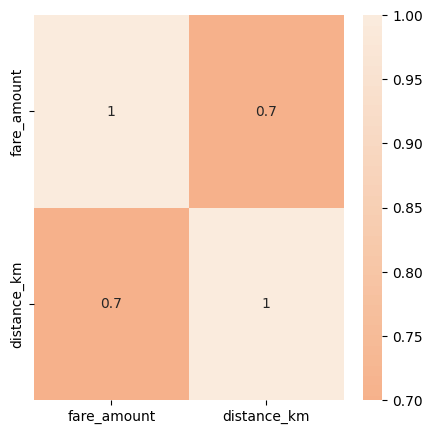

In [25]:
data = train_df_imputed[['fare_amount', 'distance_km']]
corr = data.corr().round(1)
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, cmap='rocket', center=0)
plt.show()

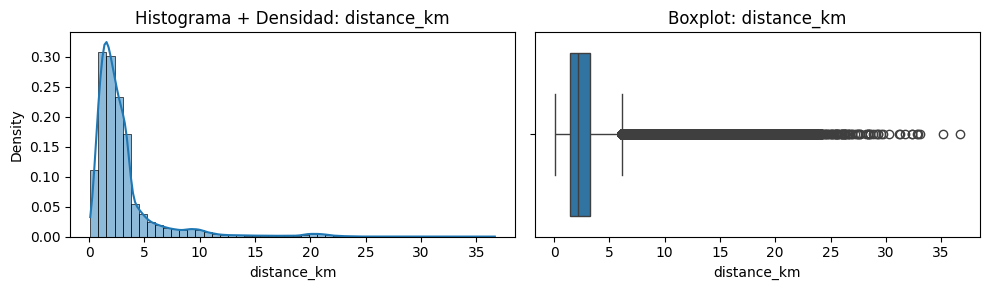

In [26]:
densityHistBoxPlot(train_df, ["distance_km"])

Vemos que hay una distribución marcada a la izquierda, mostrando una preferencia hacia los viajes cortos.

# Regresión lineal

In [27]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred = linear_model.predict(x_test)

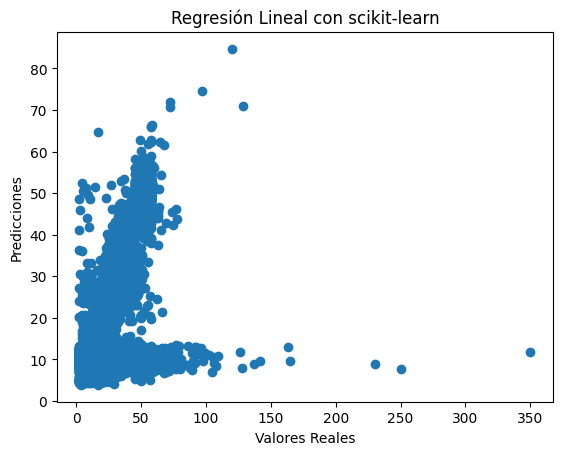

In [28]:
plt.scatter(y_test, y_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Regresión Lineal con scikit-learn")
plt.show()

In [29]:
# Métricas del modelo
mse_selfeat = mean_squared_error(y_test, y_pred)
r2_selfeat = r2_score(y_test, y_pred)
score_selfeat = linear_model.score(x_test, y_test)
score_selfeat_train = linear_model.score(x_train, y_train)
print(f"Puntaje train: {score_selfeat_train}")
print(f"Puntaje test: {score_selfeat}")

print(f'Error cuadrático medio (MSE) con features seleccionadas: {mse_selfeat:.2f}')
print(f'Coeficiente de determinación (R^2) con features seleccionadas: {r2_selfeat:.2f}\n')

Puntaje train: 0.5139208205789947
Puntaje test: 0.5147860649332869
Error cuadrático medio (MSE) con features seleccionadas: 47.93
Coeficiente de determinación (R^2) con features seleccionadas: 0.51



In [30]:
def resPlot(modelo, nombre_modelo, x_test, y_test):
    pred = modelo.predict(x_test)

    if hasattr(y_test, 'values'):
        y_test_array = y_test.values.ravel()
    else:
        y_test_array = y_test.ravel()

    pred = pred.ravel()

    plt.figure(figsize=(5,3))
    plt.scatter(pred, y_test_array - pred, s=6, alpha=0.6)
    plt.axhline(0, color='k')
    plt.title(f"Residuals - {nombre_modelo}")
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(8,4))
    fig.suptitle(f'Residuos porcentuales - {nombre_modelo}')
    plt.xlabel('y_test')
    plt.ylabel('Residuos (%)')

    percentage_residuals = np.where(y_test_array != 0,
                                   100 * (y_test_array - pred) / y_test_array,
                                   0)
    plt.scatter(y_test_array, percentage_residuals, s=6, alpha=0.6)
    plt.axhline(0, color='k')
    plt.show()

    mse = mean_squared_error(y_test_array, pred)
    r2 = r2_score(y_test_array, pred)

    print(f"{nombre_modelo} -> MSE: {mse:.4f}, R²: {r2:.4f}")
    return mse, r2

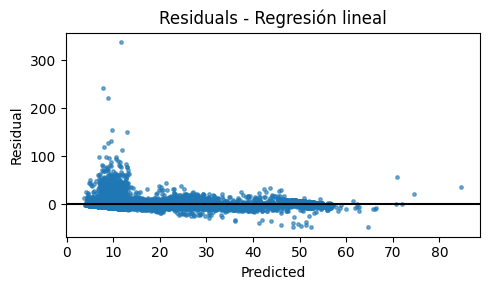

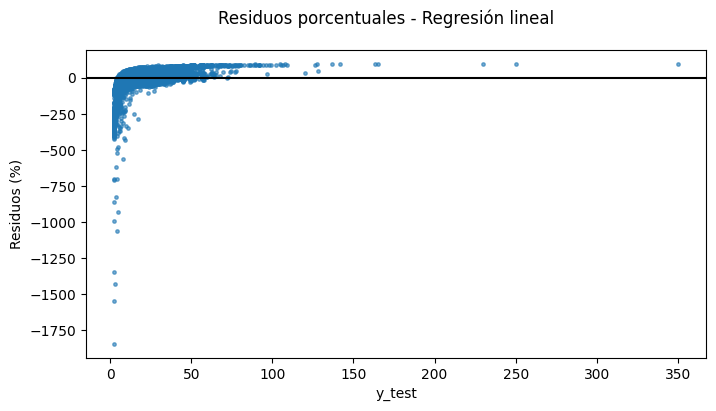

Regresión lineal -> MSE: 47.9302, R²: 0.5148


(47.93021273597209, 0.5147860649332869)

In [31]:
resPlot(linear_model, 'Regresión lineal', x_test, y_test)

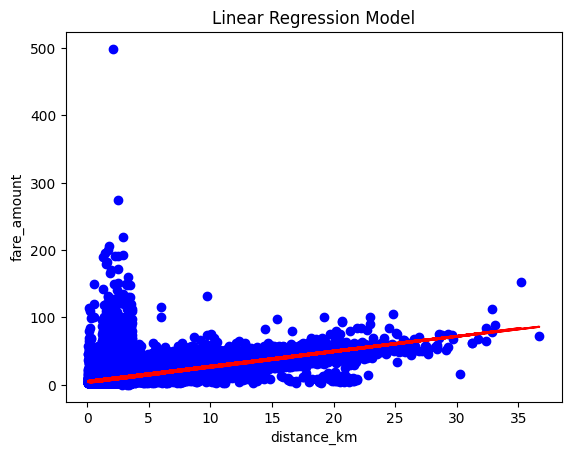

In [32]:
plt.scatter(x_train['distance_km'], y_train, color='blue')
plt.plot(x_train['distance_km'], linear_model.predict(x_train), color='red')

plt.xlabel('distance_km')
plt.ylabel('fare_amount')
plt.title('Linear Regression Model')

plt.show()

# Descenso por gradiente

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.125, random_state=0)

In [60]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, tol=1e-6, patience=10):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy().reshape(-1, 1)  # Ensure shape (n, 1)
    X_val = X_val.to_numpy()
    y_val = y_val.to_numpy().reshape(-1, 1)

    n = X_train.shape[0]
    m = X_train.shape[1]
    o = X_val.shape[0]

    # Add bias column
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # Initialize weights
    W = np.random.randn(m + 1, 1)

    train_errors = []
    val_errors = []
    train_r2_scores = []
    val_r2_scores = []
    best_val_mse = float('inf')
    best_W = W.copy()
    patience_counter = 0

    for epoch in range(epochs):
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)
        train_r2 = r2_score(y_train, prediction_train)
        train_r2_scores.append(train_r2)

        prediction_val = np.matmul(X_val, W)
        error_val = y_val - prediction_val
        val_mse = np.mean(error_val ** 2)
        val_errors.append(val_mse)
        val_r2 = r2_score(y_val, prediction_val)
        val_r2_scores.append(val_r2)

        # Early stopping
        if val_mse < best_val_mse - tol:
            best_val_mse = val_mse
            best_W = W.copy()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            W = best_W
            break

        gradient = -2 / n * np.matmul(X_train.T, error_train)
        W = W - (lr * gradient)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Train MSE: {train_mse:.6f}, Val MSE: {val_mse:.6f}")
            print(f"Epoch {epoch + 1}/{epochs}, Train R2: {train_r2:.6f}, Val R2: {val_r2:.6f}")

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(val_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    plt.show()

    return

def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, tol=1e-6, patience=10):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy().reshape(-1, 1)
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy().reshape(-1, 1)

    n = X_train.shape[0]
    m = X_train.shape[1]
    o = X_test.shape[0]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))

    W = np.random.randn(m + 1, 1)
    train_errors = []
    test_errors = []
    train_r2_scores = []
    test_r2_scores = []
    best_test_mse = float('inf')
    best_W = W.copy()
    patience_counter = 0

    for i in range(epochs):
        permutation = np.random.permutation(n)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]
        epoch_train_errors = []

        for j in range(n):
            x_sample = X_train_shuffled[j:j+1]
            y_sample = y_train_shuffled[j:j+1]
            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            sample_mse = np.mean(error ** 2)
            epoch_train_errors.append(sample_mse)
            gradient = -2 * np.matmul(x_sample.T, error)
            W = W - (lr * gradient)

        avg_train_error = np.mean(epoch_train_errors)
        train_errors.append(avg_train_error)
        prediction_train = np.matmul(X_train, W)
        train_r2 = r2_score(y_train, prediction_train)
        train_r2_scores.append(train_r2)

        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)
        test_r2 = r2_score(y_test, prediction_test)
        test_r2_scores.append(test_r2)

        if test_mse < best_test_mse - tol:
            best_test_mse = test_mse
            best_W = W.copy()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {i + 1}")
            W = best_W
            break

        if (i + 1) % 10 == 0:
            print(f"Epoch {i + 1}/{epochs}, Train MSE: {avg_train_error:.6f}, Test MSE: {test_mse:.6f}")
            print(f"Epoch {i + 1}/{epochs}, Train R2: {train_r2:.6f}, Test R2: {test_r2:.6f}")

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return

def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=32, tol=1e-6, patience=10):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy().reshape(-1, 1)
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy().reshape(-1, 1)

    n = X_train.shape[0]
    m = X_train.shape[1]
    o = X_test.shape[0]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))

    W = np.random.randn(m + 1, 1)
    train_errors = []
    test_errors = []
    train_r2_scores = []
    test_r2_scores = []
    best_test_mse = float('inf')
    best_W = W.copy()
    patience_counter = 0

    for i in range(epochs):
        permutation = np.random.permutation(n)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]
        epoch_train_errors = []

        for j in range(0, n, batch_size):
            end_idx = min(j + batch_size, n)
            x_batch = X_train_shuffled[j:end_idx]
            y_batch = y_train_shuffled[j:end_idx]
            current_batch_size = end_idx - j
            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            batch_mse = np.mean(error ** 2)
            epoch_train_errors.append(batch_mse)
            gradient = -2 / current_batch_size * np.matmul(x_batch.T, error)
            W = W - (lr * gradient)

        avg_train_error = np.mean(epoch_train_errors)
        train_errors.append(avg_train_error)
        prediction_train = np.matmul(X_train, W)
        train_r2 = r2_score(y_train, prediction_train)
        train_r2_scores.append(train_r2)

        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)
        test_r2 = r2_score(y_test, prediction_test)
        test_r2_scores.append(test_r2)

        if test_mse < best_test_mse - tol:
            best_test_mse = test_mse
            best_W = W.copy()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {i + 1}")
            W = best_W
            break

        if (i + 1) % 10 == 0:
            print(f"Epoch {i + 1}/{epochs}, Train MSE: {avg_train_error:.6f}, Test MSE: {test_mse:.6f}")
            print(f"Epoch {i + 1}/{epochs}, Train R2: {train_r2:.6f}, Test R2: {test_r2:.6f}")

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return

A través de los distintos casos es descenso por gradiente, fuimos optimizando los hiperparámetros a mano a través de observar cómo se iba reduciendo el MSE y mejorando el $R^2$ (en cada caso)

Epoch 10/1500, Train MSE: 112.784175, Val MSE: 111.479583
Epoch 10/1500, Train R2: -0.150370, Val R2: -0.165349
Epoch 20/1500, Train MSE: 112.305303, Val MSE: 111.002365
Epoch 20/1500, Train R2: -0.145486, Val R2: -0.160360
Epoch 30/1500, Train MSE: 111.830389, Val MSE: 110.529086
Epoch 30/1500, Train R2: -0.140642, Val R2: -0.155413
Epoch 40/1500, Train MSE: 111.359402, Val MSE: 110.059714
Epoch 40/1500, Train R2: -0.135838, Val R2: -0.150506
Epoch 50/1500, Train MSE: 110.892308, Val MSE: 109.594216
Epoch 50/1500, Train R2: -0.131074, Val R2: -0.145640
Epoch 60/1500, Train MSE: 110.429075, Val MSE: 109.132560
Epoch 60/1500, Train R2: -0.126349, Val R2: -0.140815
Epoch 70/1500, Train MSE: 109.969672, Val MSE: 108.674714
Epoch 70/1500, Train R2: -0.121663, Val R2: -0.136028
Epoch 80/1500, Train MSE: 109.514066, Val MSE: 108.220646
Epoch 80/1500, Train R2: -0.117016, Val R2: -0.131282
Epoch 90/1500, Train MSE: 109.062226, Val MSE: 107.770326
Epoch 90/1500, Train R2: -0.112407, Val R2: -0

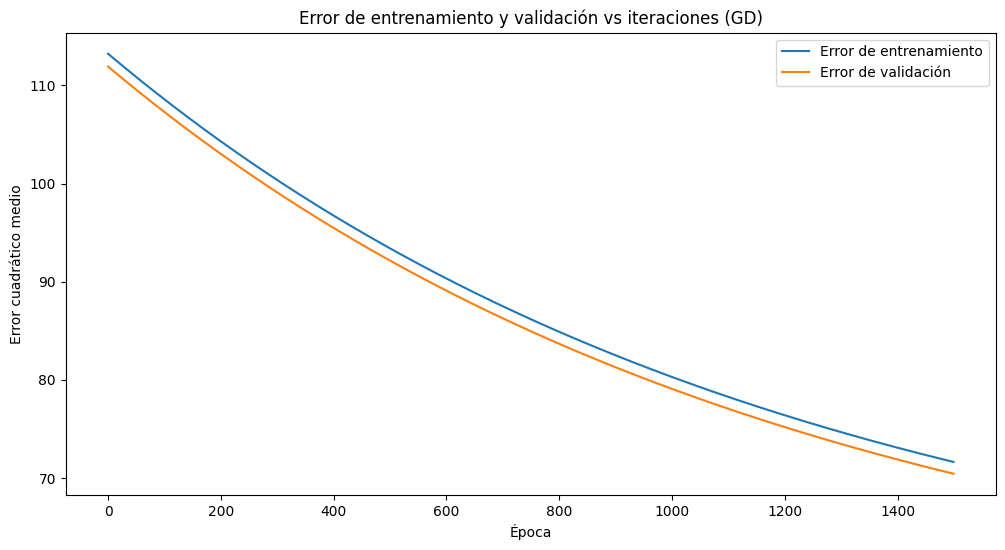

In [64]:
# gradient_descent(x_train, y_train, x_test, y_test, lr=0.01, epochs=20)
# gradient_descent(x_train, y_train, x_test, y_test, lr=0.1, epochs=20)
# gradient_descent(x_train, y_train, x_test, y_test, lr=0.0001, epochs=50)
# gradient_descent(x_train, y_train, x_test, y_test, lr=1e-6, epochs=100)
# gradient_descent(x_train, y_train, x_test, y_test, lr=1e-6, epochs=200)
# gradient_descent(x_train, y_train, x_test, y_test, lr=1e-6, epochs=500)
# gradient_descent(x_train, y_train, x_test, y_test, lr=1e-5, epochs=800)
gradient_descent(x_train, y_train, x_test, y_test, lr=1e-5, epochs=1500)

Epoch 10/50, Train MSE: 48.369902, Test MSE: 46.986490
Epoch 10/50, Train R2: 0.507301, Test R2: 0.508828
Epoch 20/50, Train MSE: 47.848820, Test MSE: 46.513442
Epoch 20/50, Train R2: 0.512006, Test R2: 0.513773
Epoch 30/50, Train MSE: 47.767485, Test MSE: 46.428958
Epoch 30/50, Train R2: 0.512821, Test R2: 0.514656
Epoch 40/50, Train MSE: 47.739509, Test MSE: 46.402807
Epoch 40/50, Train R2: 0.513045, Test R2: 0.514929
Epoch 50/50, Train MSE: 47.727877, Test MSE: 46.381794
Epoch 50/50, Train R2: 0.513215, Test R2: 0.515149


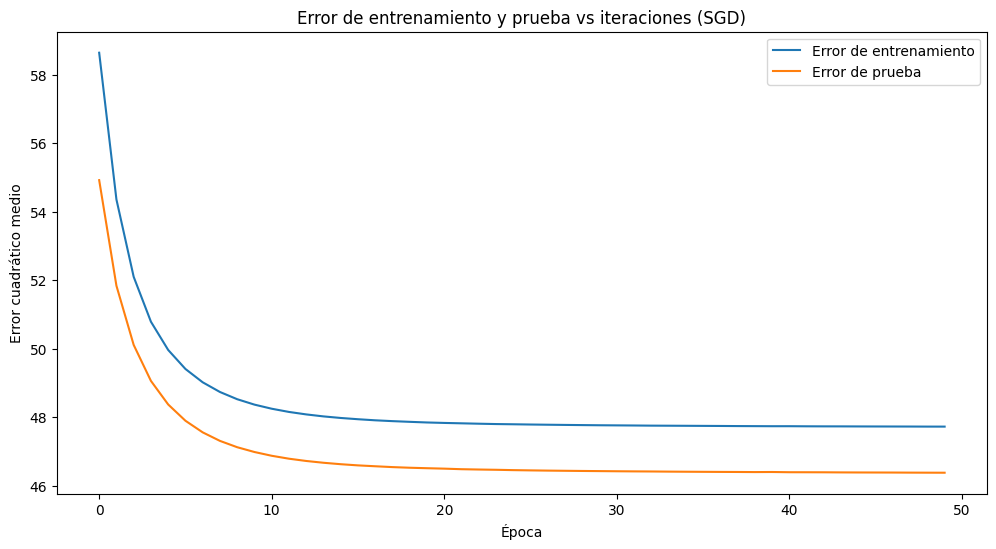

In [36]:
# stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.01, epochs=50)
# stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.01, epochs=70)
# stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.001, epochs=70)
# stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.0001, epochs=70)
# stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.0001, epochs=100)
# stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.00001, epochs=100)
# stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.000001, epochs=50)
stochastic_gradient_descent(x_train, y_train, x_test, y_test, lr=0.000001, epochs=50)

Epoch 10/30, Train MSE: 49.597756, Test MSE: 48.245892
Epoch 10/30, Train R2: 0.495545, Test R2: 0.495663
Epoch 20/30, Train MSE: 48.408395, Test MSE: 47.138135
Epoch 20/30, Train R2: 0.506598, Test R2: 0.507243
Epoch 30/30, Train MSE: 47.994374, Test MSE: 46.742162
Epoch 30/30, Train R2: 0.510401, Test R2: 0.511382


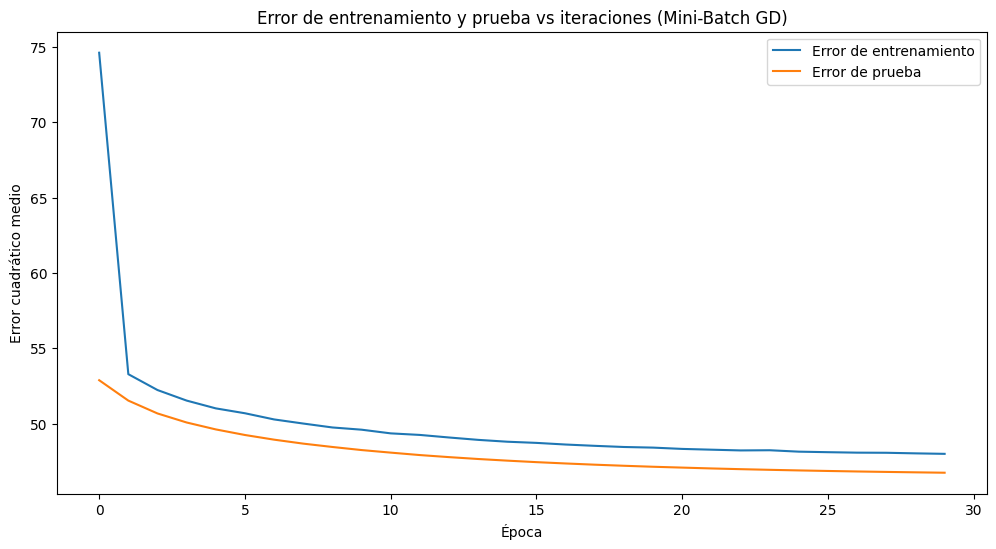

In [37]:
# mini_batch_gradient_descent(x_train, y_train, x_test, y_test, lr=0.01, epochs=100, batch_size=128)
# mini_batch_gradient_descent(x_train, y_train, x_test, y_test, lr=0.001, epochs=20, batch_size=64)
# mini_batch_gradient_descent(x_train, y_train, x_test, y_test, lr=0.0001, epochs=20, batch_size=64)
# mini_batch_gradient_descent(x_train, y_train, x_test, y_test, lr=0.0001, epochs=20, batch_size=96)
# mini_batch_gradient_descent(x_train, y_train, x_test, y_test, lr=0.0001, epochs=10, batch_size=128)
mini_batch_gradient_descent(x_train, y_train, x_test, y_test, lr=0.0001, epochs=30, batch_size=96)
# mini_batch_gradient_descent(x_train, y_train, x_test, y_test, lr=0.001, epochs=50, batch_size=32)

En cada caso se puede observar que el $R^2$ tiende a mantenerse a medida que aumentan las épocas y que el error de testeo es menor al de training, además de disminuir levemente con las épocas. A su vez, los únicos casos en que parece mejorar el modelo de la regresión lineal son los de estocástico y de mini batch.

# Regularización

Coeficientes del modelo de regresión lineal:
[[ 1.3011248   1.23548526 -0.69258019  0.3670759  -0.05594938 -0.22864889
  -0.14245207 -0.24207953 -0.06858149 -0.15619517 -0.29716717  2.25233801]]
0.5136423086278717

Coeficientes del modelo Lasso:
[ 1.24353128  1.17691382 -0.69194453  0.36643257 -0.05550918 -0.22898023
 -0.14081733 -0.23933886 -0.06743496 -0.15230027 -0.29459524  2.25232622]
0.5136421752739894

Coeficientes del modelo Ridge:
[ 1.30112428  1.23548473 -0.69258019  0.3670759  -0.05594938 -0.22864889
 -0.14245207 -0.24207953 -0.06858149 -0.15619516 -0.29716716  2.25233801]
0.5136423086278717
alpha =  0.0001


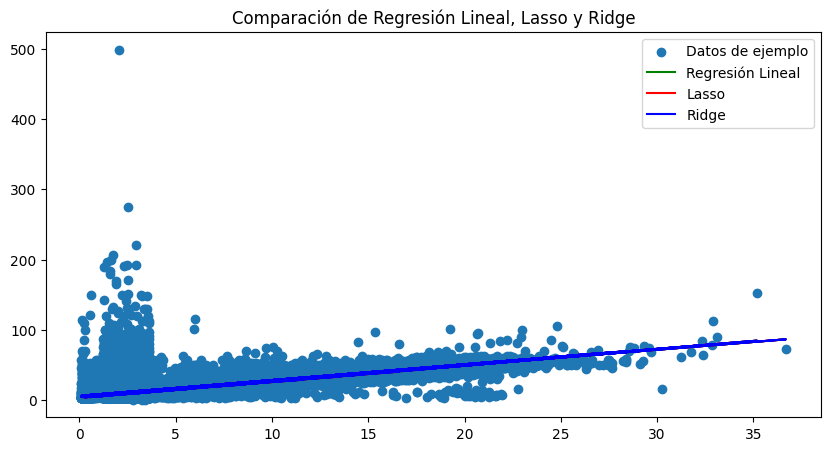

Coeficientes del modelo de regresión lineal:
[[ 1.3011248   1.23548526 -0.69258019  0.3670759  -0.05594938 -0.22864889
  -0.14245207 -0.24207953 -0.06858149 -0.15619517 -0.29716717  2.25233801]]
0.5136423086278717

Coeficientes del modelo Lasso:
[ 0.72580537  0.65038432 -0.686224    0.36064261 -0.05154733 -0.23196184
 -0.12610476 -0.21467191 -0.05711717 -0.11724667 -0.27144674  2.25222009]
0.5136289985475423

Coeficientes del modelo Ridge:
[ 1.30111963  1.23548    -0.69258016  0.36707588 -0.05594938 -0.22864889
 -0.14245206 -0.24207949 -0.06858148 -0.15619512 -0.29716712  2.252338  ]
0.5136423086278707
alpha =  0.001


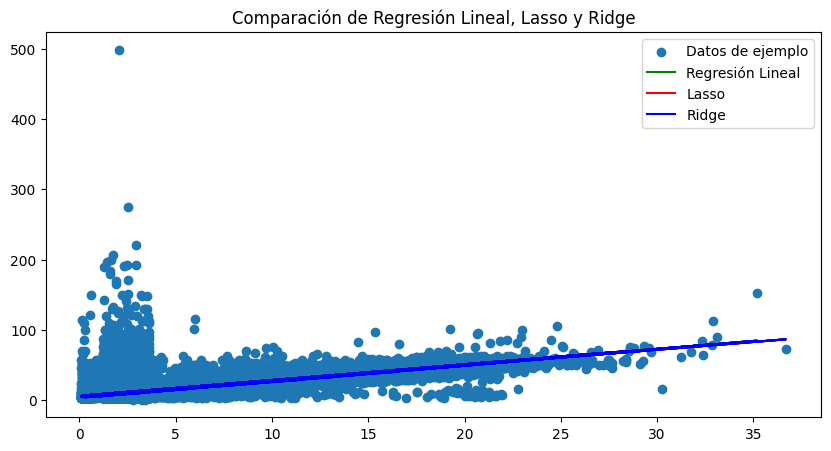

Coeficientes del modelo de regresión lineal:
[[ 1.3011248   1.23548526 -0.69258019  0.3670759  -0.05594938 -0.22864889
  -0.14245207 -0.24207953 -0.06858149 -0.15619517 -0.29716717  2.25233801]]
0.5136423086278717

Coeficientes del modelo Lasso:
[ 0.         -0.         -0.63199572  0.30307006 -0.01883354 -0.23988803
 -0.11145136 -0.02544754 -0.          0.         -0.03052603  2.25078454]
0.5135070085123088

Coeficientes del modelo Ridge:
[ 1.30107314  1.23543273 -0.6925799   0.36707571 -0.05594937 -0.22864888
 -0.14245196 -0.2420791  -0.06858144 -0.15619468 -0.29716666  2.25233799]
0.5136423086277748
alpha =  0.01


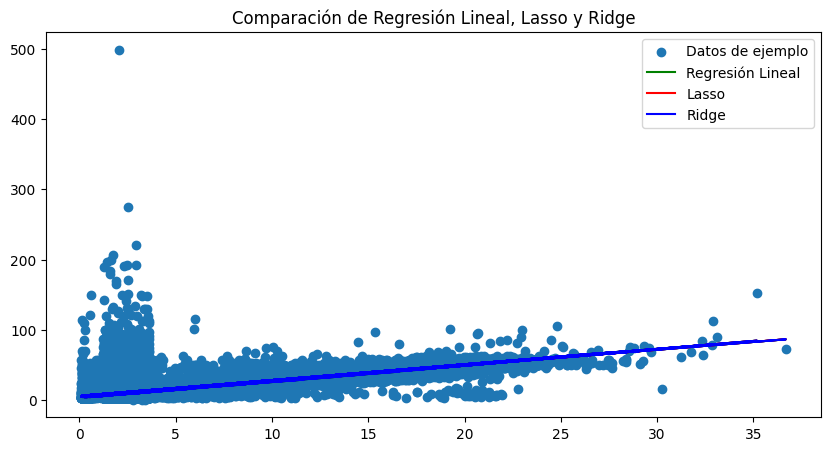

Coeficientes del modelo de regresión lineal:
[[ 1.3011248   1.23548526 -0.69258019  0.3670759  -0.05594938 -0.22864889
  -0.14245207 -0.24207953 -0.06858149 -0.15619517 -0.29716717  2.25233801]]
0.5136423086278717

Coeficientes del modelo Lasso:
[ 0.         -0.         -0.18334173  0.         -0.         -0.05237435
 -0.         -0.         -0.          0.         -0.          2.23663769]
0.512484766470692

Coeficientes del modelo Ridge:
[ 1.30060835  1.23496017 -0.69257725  0.36707399 -0.05594926 -0.22864881
 -0.14245097 -0.24207521 -0.06858098 -0.15619032 -0.29716209  2.25233786]
0.5136423086182045
alpha =  0.1


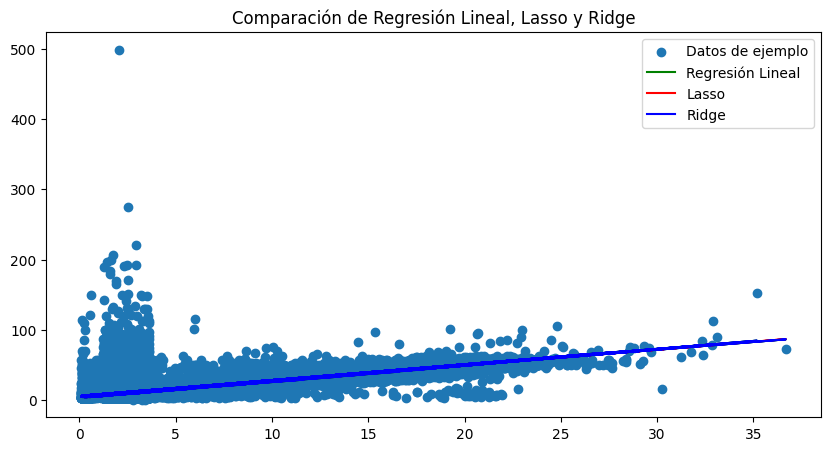

Coeficientes del modelo de regresión lineal:
[[ 1.3011248   1.23548526 -0.69258019  0.3670759  -0.05594938 -0.22864889
  -0.14245207 -0.24207953 -0.06858149 -0.15619517 -0.29716717  2.25233801]]
0.5136423086278717

Coeficientes del modelo Lasso:
[ 0.         -0.         -0.          0.          0.         -0.
 -0.         -0.         -0.          0.         -0.          2.14468748]
0.510888325222744

Coeficientes del modelo Ridge:
[ 1.2959793   1.23025374 -0.69255084  0.36705679 -0.05594816 -0.22864809
 -0.14244105 -0.24203632 -0.06857639 -0.15614668 -0.29711636  2.25233651]
0.5136423076682156
alpha =  1


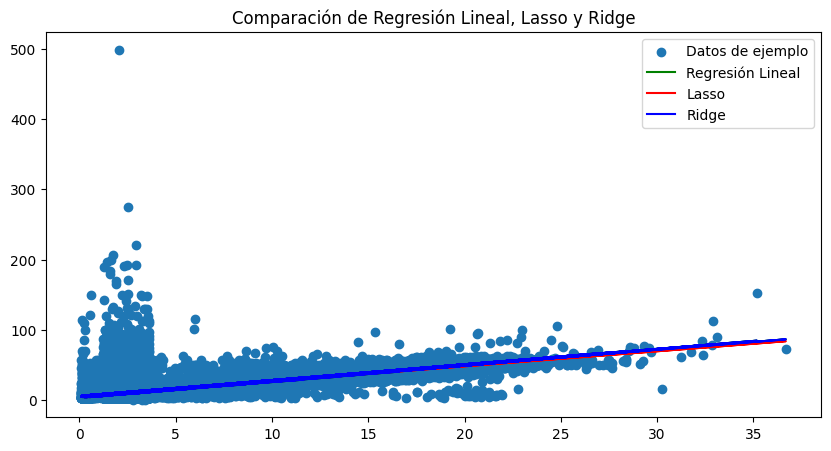

Coeficientes del modelo de regresión lineal:
[[ 1.3011248   1.23548526 -0.69258019  0.3670759  -0.05594938 -0.22864889
  -0.14245207 -0.24207953 -0.06858149 -0.15619517 -0.29716717  2.25233801]]
0.5136423086278717

Coeficientes del modelo Lasso:
[ 0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.          1.24079852]
0.4094744702230638

Coeficientes del modelo Ridge:
[ 1.2514971   1.18502933 -0.69228797  0.36688491 -0.05593686 -0.22863966
 -0.14234208 -0.24164587 -0.0685332  -0.15571233 -0.29665729  2.25232291]
0.5136422193260942
alpha =  10


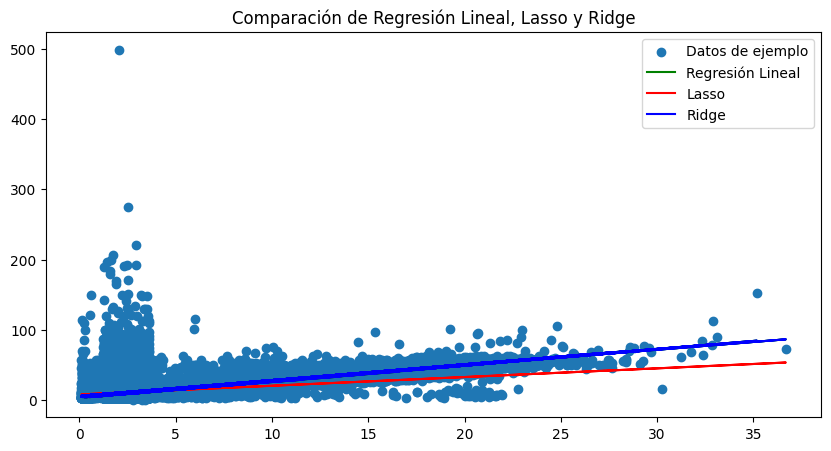

Coeficientes del modelo de regresión lineal:
[[ 1.3011248   1.23548526 -0.69258019  0.3670759  -0.05594938 -0.22864889
  -0.14245207 -0.24207953 -0.06858149 -0.15619517 -0.29716717  2.25233801]]
0.5136423086278717

Coeficientes del modelo Lasso:
[ 0. -0.  0. -0. -0.  0. -0. -0.  0.  0. -0.  0.]
0.0

Coeficientes del modelo Ridge:
[ 0.93488945  0.86324035 -0.68974837  0.36517513 -0.05580437 -0.22846757
 -0.14137465 -0.23765737 -0.0682857  -0.15153259 -0.29197242  2.25217802]
0.5136374250828675
alpha =  100


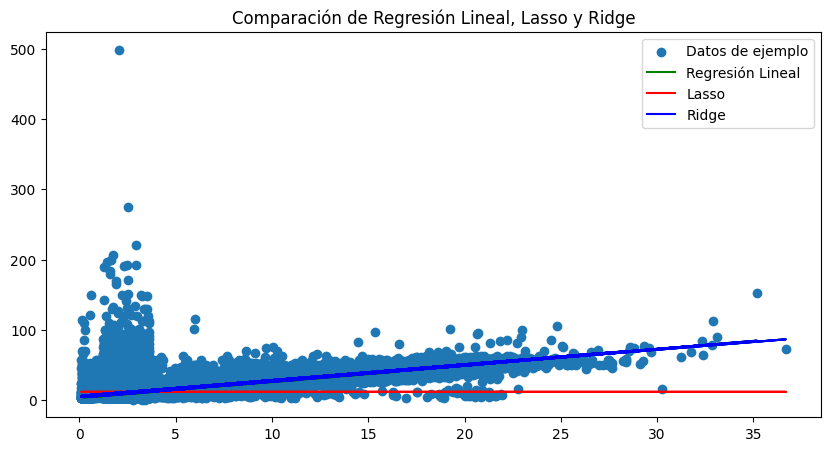

Coeficientes del modelo de regresión lineal:
[[ 1.3011248   1.23548526 -0.69258019  0.3670759  -0.05594938 -0.22864889
  -0.14245207 -0.24207953 -0.06858149 -0.15619517 -0.29716717  2.25233801]]
0.5136423086278717

Coeficientes del modelo Lasso:
[ 0. -0.  0. -0. -0.  0. -0. -0.  0.  0. -0.  0.]
0.0

Coeficientes del modelo Ridge:
[ 0.28842844  0.20888239 -0.6668025   0.34884915 -0.05410649 -0.22512571
 -0.13326147 -0.20195904 -0.06922932 -0.1182836  -0.25018826  2.2505595 ]
0.5136014690650068
alpha =  1000


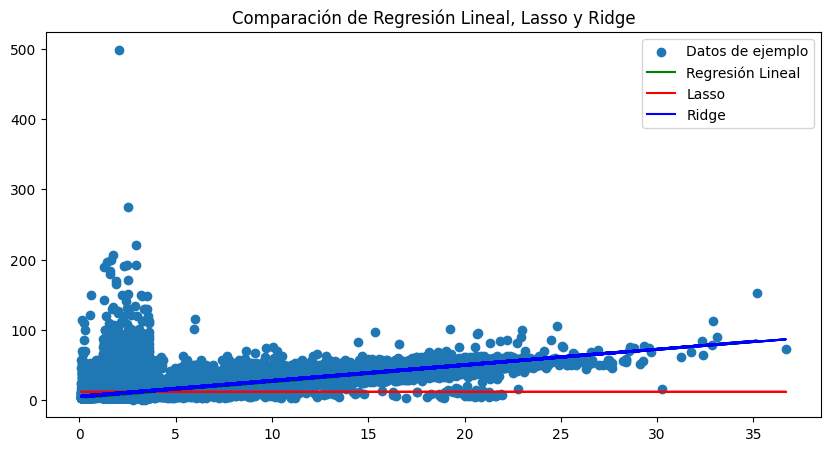

Coeficientes del modelo de regresión lineal:
[[ 1.3011248   1.23548526 -0.69258019  0.3670759  -0.05594938 -0.22864889
  -0.14245207 -0.24207953 -0.06858149 -0.15619517 -0.29716717  2.25233801]]
0.5136423086278717

Coeficientes del modelo Lasso:
[ 0. -0.  0. -0. -0.  0. -0. -0.  0.  0. -0.  0.]
0.0

Coeficientes del modelo Ridge:
[ 6.03615725e-02  5.37695910e-04 -5.03439742e-01  2.37147360e-01
 -3.93357698e-02 -1.96308266e-01 -1.01521929e-01 -8.17255670e-02
 -7.42797641e-02 -1.41750561e-02 -1.10943927e-01  2.23455355e+00]
0.5134325744725432
alpha =  10000


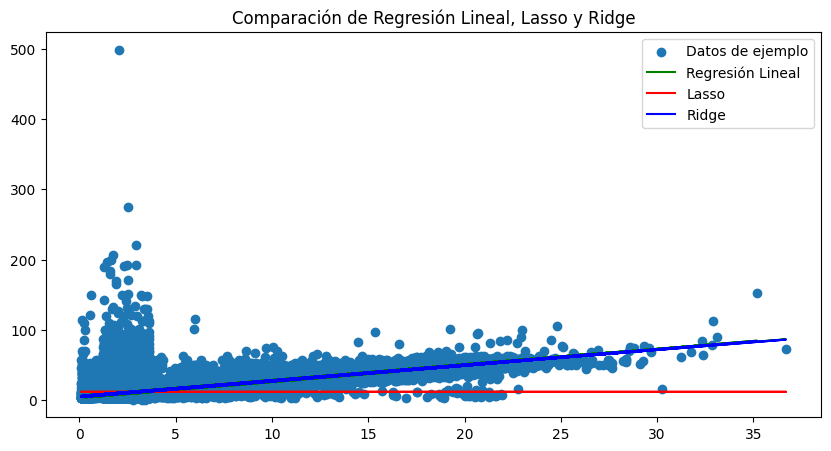

Coeficientes del modelo de regresión lineal:
[[ 1.3011248   1.23548526 -0.69258019  0.3670759  -0.05594938 -0.22864889
  -0.14245207 -0.24207953 -0.06858149 -0.15619517 -0.29716717  2.25233801]]
0.5136423086278717

Coeficientes del modelo Lasso:
[ 0. -0.  0. -0. -0.  0. -0. -0.  0.  0. -0.  0.]
0.0

Coeficientes del modelo Ridge:
[ 0.01103532 -0.00461552 -0.14335171  0.04416143 -0.00638956 -0.09041874
 -0.05159171 -0.01479236 -0.04249859  0.02122859 -0.02562385  2.09639068]
0.510337229353188
alpha =  100000


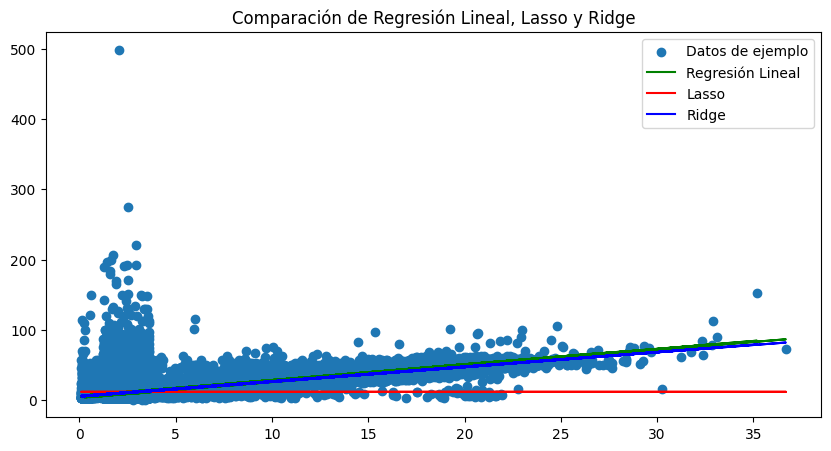

Coeficientes del modelo de regresión lineal:
[[ 1.3011248   1.23548526 -0.69258019  0.3670759  -0.05594938 -0.22864889
  -0.14245207 -0.24207953 -0.06858149 -0.15619517 -0.29716717  2.25233801]]
0.5136423086278717

Coeficientes del modelo Lasso:
[ 0. -0.  0. -0. -0.  0. -0. -0.  0.  0. -0.  0.]
0.0

Coeficientes del modelo Ridge:
[ 1.21435184e-03 -4.84790904e-04 -1.11994368e-02  7.55572211e-05
 -5.90583290e-04 -8.88971712e-03 -1.14406880e-02 -5.13206349e-03
 -4.25057743e-03  6.51824671e-03 -2.48620363e-03  1.30729145e+00]
0.422654795477023
alpha =  1000000


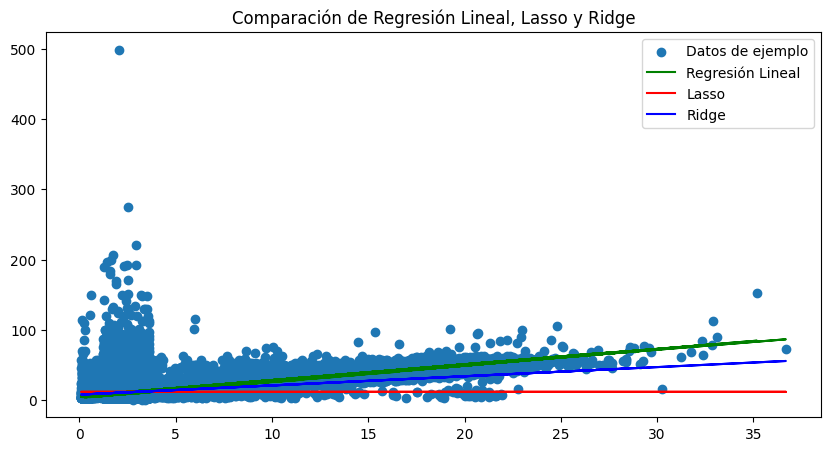

In [38]:
alphas = [10**i for i in range(-4, 7)]

for a in alphas:
    lasso = Lasso(alpha=a)  # alpha controla la fuerza de la regularización L1 (Lasso)
    ridge = Ridge(alpha=a)  # alpha controla la fuerza de la regularización L2 (Ridge)
    # elasticnet = ElasticNet(alpha=a, l1_ratio=0.3)

    # Ajustar modelos a los datos
    linear_model.fit(x_train, y_train)
    lasso.fit(x_train, y_train)
    ridge.fit(x_train, y_train)
    # elasticnet.fit(x_train, y_train)

    # Mostrar coeficientes
    print("Coeficientes del modelo de regresión lineal:")
    print(linear_model.coef_)
    print(linear_model.score(x_train, y_train))

    print("\nCoeficientes del modelo Lasso:")
    print(lasso.coef_)
    print(lasso.score(x_train, y_train))


    print("\nCoeficientes del modelo Ridge:")
    print(ridge.coef_)
    print(ridge.score(x_train, y_train))


    # print("\nCoeficientes del modelo ElasticNet:")
    # print(elasticnet.coef_)
    # print(elasticnet.score(x_train, y_train))

    print("alpha = ", a)

    # Graficar resultados
    plt.figure(figsize=(10, 5))

    plt.scatter(x_train["distance_km"], y_train, label='Datos de ejemplo')
    plt.plot(x_train["distance_km"], linear_model.predict(x_train), label='Regresión Lineal', color='green')
    plt.plot(x_train["distance_km"], lasso.predict(x_train), label='Lasso', color='red')
    plt.plot(x_train["distance_km"], ridge.predict(x_train), label='Ridge', color='blue')
    # plt.plot(x_train["distance_km"], elasticnet.predict(x_train), label='ElasticNet', color='purple')

    plt.legend()
    plt.title('Comparación de Regresión Lineal, Lasso y Ridge')
    plt.show()


A medida que aumenta el valor de alpha en el modelo de Lasso se puede observar que los coeficientes se van haciendo 0, alejándose de los datos. Sin embargo, para valores más chicos de alpha, los coeficientes y el $R^2$ son similares a los de la regresión lineal.

En el caso de Ridge, los coeficientes se reducen pero se mantienen cercanos a los de la regresión lineal. Su $R^2$ también es muy similar al de la regresión linea.

Coeficientes del modelo de regresión lineal:
[[ 1.3011248   1.23548526 -0.69258019  0.3670759  -0.05594938 -0.22864889
  -0.14245207 -0.24207953 -0.06858149 -0.15619517 -0.29716717  2.25233801]]
0.5136423086278717

Coeficientes del modelo Lasso:
[ 0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.          1.74295906]
0.4863031482531244

Coeficientes del modelo Ridge:
[ 1.27581153  1.20974915 -0.69243374  0.36698038 -0.0559432  -0.22864462
 -0.14239701 -0.24186312 -0.06855662 -0.1559532  -0.29691271  2.25233049]
0.5136422853992659

Coeficientes del modelo ElasticNet:
[ 0.        -0.        -0.         0.        -0.        -0.
 -0.        -0.        -0.         0.        -0.         1.5497242]
0.46280150511133933


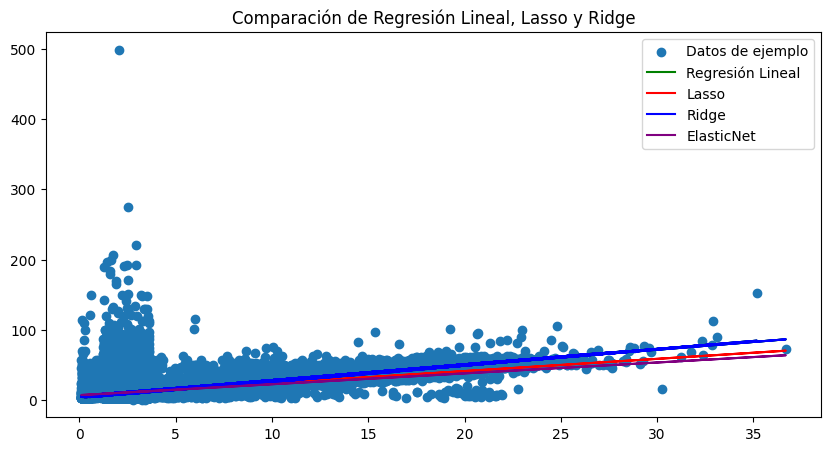

In [39]:
lasso = Lasso(alpha=5)  # alpha controla la fuerza de la regularización L1 (Lasso)
ridge = Ridge(alpha=5)  # alpha controla la fuerza de la regularización L2 (Ridge)
elasticnet = ElasticNet(alpha=5, l1_ratio=0.3)

# Ajustar modelos a los datos
linear_model.fit(x_train, y_train)
lasso.fit(x_train, y_train)
ridge.fit(x_train, y_train)
elasticnet.fit(x_train, y_train)

# Mostrar coeficientes
print("Coeficientes del modelo de regresión lineal:")
print(linear_model.coef_)
print(linear_model.score(x_train, y_train))

print("\nCoeficientes del modelo Lasso:")
print(lasso.coef_)
print(lasso.score(x_train, y_train))


print("\nCoeficientes del modelo Ridge:")
print(ridge.coef_)
print(ridge.score(x_train, y_train))


print("\nCoeficientes del modelo ElasticNet:")
print(elasticnet.coef_)
print(elasticnet.score(x_train, y_train))

# Graficar resultados
plt.figure(figsize=(10, 5))

plt.scatter(x_train["distance_km"], y_train, label='Datos de ejemplo')
plt.plot(x_train["distance_km"], linear_model.predict(x_train), label='Regresión Lineal', color='green')
plt.plot(x_train["distance_km"], lasso.predict(x_train), label='Lasso', color='red')
plt.plot(x_train["distance_km"], ridge.predict(x_train), label='Ridge', color='blue')
plt.plot(x_train["distance_km"], elasticnet.predict(x_train), label='ElasticNet', color='purple')

plt.legend()
plt.title('Comparación de Regresión Lineal, Lasso y Ridge')
plt.show()


Los coeficientes $R^2$ resultan similares entre sí, mientras que Lasso se va corriendo a medida que se aumenta el valor de alpha

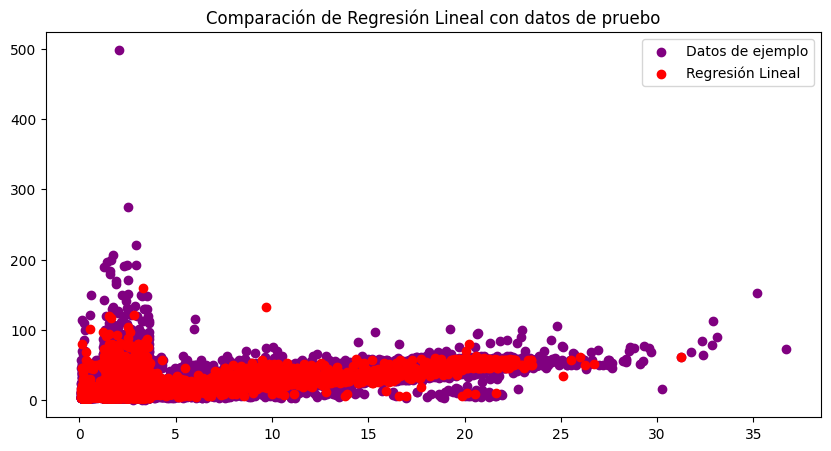

In [40]:
plt.figure(figsize=(10, 5))
plt.scatter(x_train["distance_km"], y_train, label='Datos de ejemplo', color='purple')
plt.scatter(x_test["distance_km"], y_test, label='Regresión Lineal', color='red')
plt.legend()
plt.title('Comparación de Regresión Lineal con datos de pruebo')
plt.show()

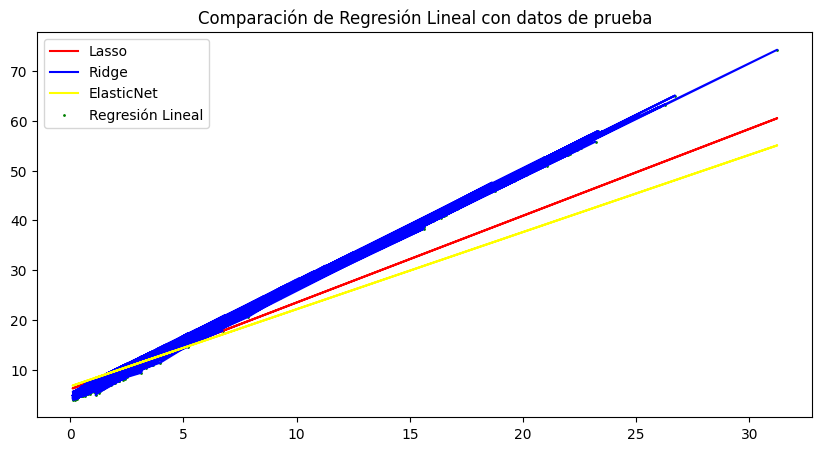

In [41]:
# Ordenamos x_test por distance_km

plt.figure(figsize=(10, 5))
plt.plot(x_test["distance_km"], lasso.predict(x_test), label='Lasso', color='red')
plt.plot(x_test["distance_km"], ridge.predict(x_test), label='Ridge', color='blue')
plt.plot(x_test["distance_km"], elasticnet.predict(x_test), label='ElasticNet', color='yellow')
plt.scatter(x_test["distance_km"], linear_model.predict(x_test), label='Regresión Lineal', color='green', s=1)

plt.legend()
plt.title('Comparación de Regresión Lineal con datos de prueba')
plt.show()


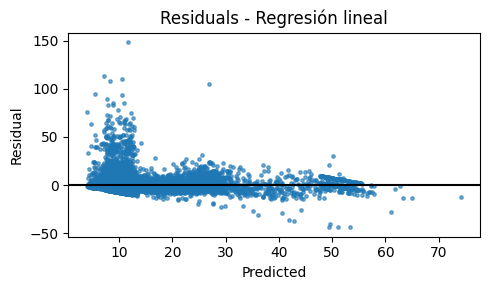

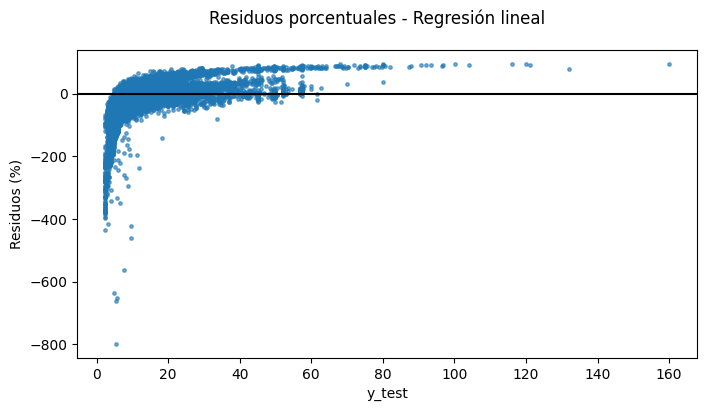

Regresión lineal -> MSE: 46.3114, R²: 0.5159


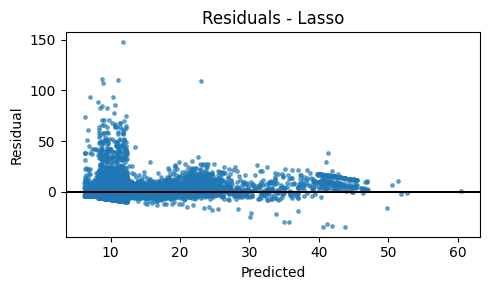

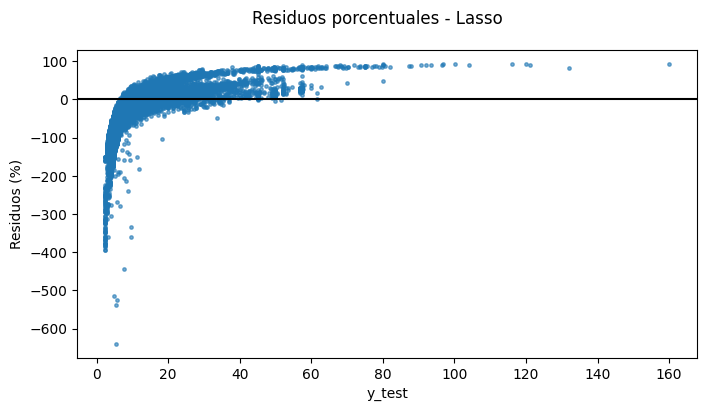

Lasso -> MSE: 48.8027, R²: 0.4898


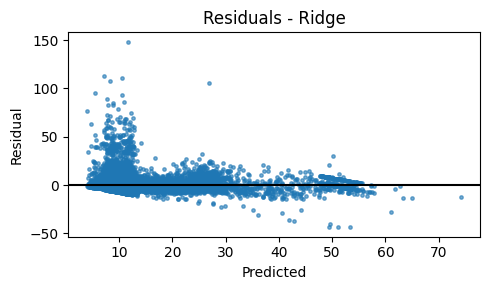

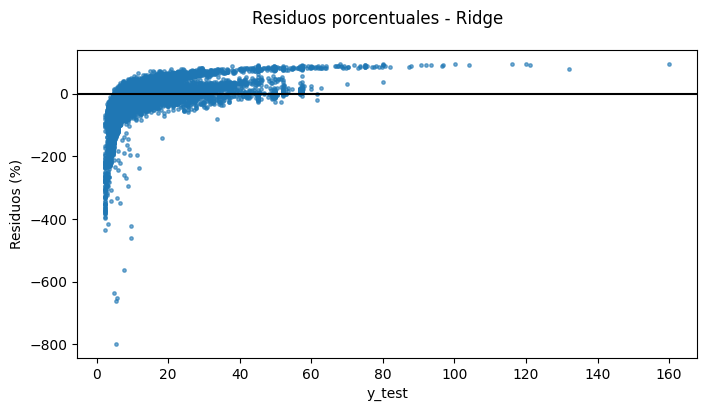

Ridge -> MSE: 46.3114, R²: 0.5159


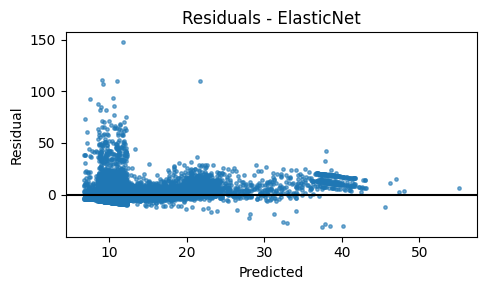

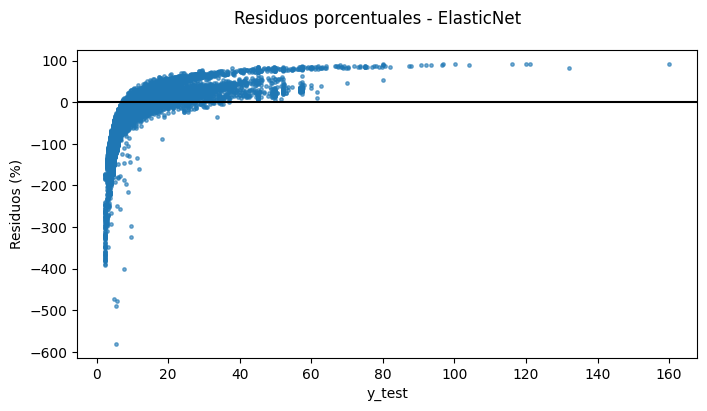

ElasticNet -> MSE: 51.0336, R²: 0.4665


(51.03359295119728, 0.4665215997647364)

In [42]:

resPlot(linear_model, 'Regresión lineal', x_test, y_test)
resPlot(lasso, 'Lasso', x_test, y_test)
resPlot(ridge, 'Ridge', x_test, y_test)
resPlot(elasticnet, 'ElasticNet', x_test, y_test)


# Conclusiones

Los resultados muestran un $R^2$ cercano a $0.5$ ($50\%$ de la variabilidad explicada), con un MSE de aproximadamente $0.46$. Los valores de training y test son en algunos casos semejantes entre sí en la regresión lineal. Si bien teóricamente indica un modelo bien balanceado sin overfitting, se considera que es necesario profundizar en la imputación de datos faltantes para las variables geográficas y el tratamiento de overfitting por outliers. Los residuos no parecen distribuirse aleatoriamente, si no que hay una concentración alrededor de $y=0$ y una concentración de errores grandes. Algo similar pasa en los residuos porcentuales, donde para valores bajos llegan hasta casi un $-1800\%$ en la regresión.

Respecto a la regularización, vemos Lasso se aleja del modelo lineal a medida que hacemos crecer el alpha, mientras que Ridge casi no ve diferencia con ese modelo, indicando coeficientes ya balanceados. Lasso se aleja progresivamente con mayor alpha, revelando variables de diferente importancia y permitiendo selección automática de características. Los valores residuales continúan sin presentar una distribución aleatoria, con casi $-700\%$ para valores pequeños.